In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import modsim.models.iq_modulator as iqm
from modsim.signal_gen.arbitrary_generator import SignalGen
import modsim.signal_gen.processing as proc
from tqdm import tqdm
%matplotlib inline

In [2]:
# instantiating signal generation
awg = SignalGen(num_of_samples = 256 * 1024, sampling_time = 25e-5, samples_per_symbol = 4)

In [33]:
# MZM settings
Ein = 1
Vpi_rf_I = 1
Vpi_rf_Q = Vpi_rf_I
Vpi_bias_I = Vpi_rf_I
Vpi_bias_Q = Vpi_rf_I
Vpi_bias_P = Vpi_rf_I
ER_model = 'Finite'
ER_dB_I = 20
ER_dB_Q = 20
ER_dB_P = 100
heaters = True

# RF settings
pulse_fmt = 'NRZ' # 'NRZ' 'PAM4'
Vpp_rf_I = 0.0 * Vpi_rf_I
Vpp_rf_Q = 0.0 * Vpi_rf_Q
f_bw = None
f_ord = 2

# heater driving definitions
Vcc = 5
R = 1
push_pull = False
pre_sqrt = True

# monitor PD out
Resp = 1
pd_bw = 100
pd_ord = 3

# bias settings
bias_dc_I = 0.0 * Vpi_bias_I - (2 / np.pi) / np.sqrt(10 ** (ER_dB_Q / 10)) * Vpi_bias_I
bias_dc_Q = 1.0 * Vpi_bias_Q + (2 / np.pi) / np.sqrt(10 ** (ER_dB_I / 10)) * Vpi_bias_Q
bias_dc_P = 0.5 * Vpi_bias_P # 0.5 # (np.sqrt(2) / 2)
Vpp_dither_I = 0.05 * Vpi_bias_I
Vpp_dither_Q = 0.05 * Vpi_bias_Q
Vpp_dither_P = 0.0 * Vpi_bias_P
f_dither_I = 3 #[Hz]
f_dither_Q = 5 #[Hz]
f_dither_P = 0 #[Hz]
Vdither_I = awg.waveform_gen(Vpp_dither_I / 2, f_dither_I, 0)
Vdither_Q = awg.waveform_gen(Vpp_dither_Q / 2, f_dither_Q, 0)
Vdither_P = awg.waveform_gen(Vpp_dither_P / 2, f_dither_P, 0)

# cross-correlation settings
deg = 1 * 22.5
delay = deg * np.pi / 180
n_cycles = 50
L_I = n_cycles * int(1 / (awg.Ts * f_dither_I)) # None
L_Q = n_cycles * int(1 / (awg.Ts * f_dither_Q)) # None

# ADC downsampling settings
down_samp = 100
Tn = down_samp * awg.Ts

# sweep settings
bias_dc_array = np.arange(0.0, 4.0, 0.05) * Vpi_bias_I
sweep_channel = 'P'

# pre-allocating array data
N_avg = 1 #100
size_out = int(awg.time.size / down_samp) + 1

V_I_dc = np.zeros((N_avg, bias_dc_array.size))
V_Q_dc = np.zeros((N_avg, bias_dc_array.size))
V_dc = np.zeros((N_avg, bias_dc_array.size))

Eout_I = np.zeros((N_avg, bias_dc_array.size, awg.time.size)) * 1j #[[0] * N_avg] * bias_dc_array.size
Eout_Q = np.zeros((N_avg, bias_dc_array.size, awg.time.size)) * 1j
Eout = np.zeros((N_avg, bias_dc_array.size, awg.time.size)) * 1j

V_I_ac = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j
V_Q_ac = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j
V_ac = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j

V_I_ac_ = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j
V_Q_ac_ = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j
V_ac_ = np.zeros((N_avg, bias_dc_array.size, size_out)) * 1j

Pow_ac_I = np.zeros((N_avg, bias_dc_array.size))
Pow_ac_Q = np.zeros((N_avg, bias_dc_array.size))
Pow_ac = np.zeros((N_avg, bias_dc_array.size))

C_I = np.zeros((N_avg, bias_dc_array.size)) * 1j
C_Q = np.zeros((N_avg, bias_dc_array.size)) * 1j
C = np.zeros((N_avg, bias_dc_array.size)) * 1j

# iterating over bias DC array
for k in tqdm(range(bias_dc_array.size)):
    
    # selecting bias port
    if sweep_channel == 'I':
        bias_dc_I = bias_dc_array[k]
        f_dither_IQ = f_dither_I
    elif sweep_channel == 'Q':
        bias_dc_Q = bias_dc_array[k]
        f_dither_IQ = f_dither_Q
    else:
        bias_dc_P = bias_dc_array[k]
        f_dither_IQ = f_dither_I + f_dither_Q
        
    L_IQ = n_cycles * int(1 / (awg.Ts * f_dither_IQ)) # None
        
    Vbias_I = bias_dc_I + Vdither_I
    Vbias_Q = bias_dc_Q + Vdither_Q
    Vbias_P = bias_dc_P + Vdither_P
        
    for l in range(N_avg):

        # generating signals
        Vrf_I = awg.pulse_sequence_gen(pulse_fmt, Vpp_rf_I / 2, f_bw = f_bw, f_order = f_ord) # [1 kbaud]
        Vrf_Q = awg.pulse_sequence_gen(pulse_fmt, Vpp_rf_Q / 2, f_bw = f_bw, f_order = f_ord) # [1 kbaud]

        # modulating RF and bias
        if heaters:

            # heater driving definitions
            Vheat_I = Vbias_I
            Vheat_Q = Vbias_Q
            Vheat_P = Vbias_P

            # square-root before applying voltage
            if pre_sqrt:
                V_I = np.sqrt(Vheat_I)
                V_Q = np.sqrt(Vheat_Q)
                V_P = np.sqrt(Vheat_P)

            else:
                V_I = Vheat_I
                V_Q = Vheat_Q
                V_P = Vheat_P

            # single heater vs. dual drive push-pull
            if push_pull:                
                Vb_I_1 = (Vcc - V_I) / 2
                Vb_Q_1 = (Vcc - V_Q) / 2
                Vb_P_1 = (Vcc - V_P) / 2

                Vb_I_2 = V_I / 2
                Vb_Q_2 = V_Q / 2
                Vb_P_2 = V_P / 2

            else:            
                Vb_I_1 = V_I
                Vb_Q_1 = V_Q
                Vb_P_1 = V_P

                Vb_I_2 = 0
                Vb_Q_2 = 0
                Vb_P_2 = 0

            Vrf_I_1 = Vrf_I / 2
            Vrf_Q_1 = Vrf_Q / 2

            Vrf_I_2 = -Vrf_I / 2
            Vrf_Q_2 = -Vrf_Q / 2

            [Eout_, Eout_I_, Eout_Q_] = iqm.lin_with_heaters(Ein,
                                         Vrf_I_1, Vrf_I_2,
                                         Vrf_Q_1, Vrf_Q_2,
                                         Vb_I_1, Vb_I_2,
                                         Vb_Q_1, Vb_Q_2,
                                         Vb_P_1, Vb_P_2,
                                         Vpi_rf_I = Vpi_rf_I,
                                         Vpi_rf_Q = Vpi_rf_Q,
                                         Vpi_bias_I = Vpi_bias_I,
                                         Vpi_bias_Q = Vpi_bias_Q,
                                         Vpi_bias_P = Vpi_bias_P,
                                         ER_model = ER_model, 
                                         ER_dB_I = ER_dB_I, 
                                         ER_dB_Q = ER_dB_Q,
                                         ER_dB_P = ER_dB_P,
                                         get_arms = True)
            
        else:
            [Eout_, Eout_I_, Eout_Q_] = iqm.linear(Ein,
                                                 Vrf_I,
                                                 Vrf_Q,
                                                 Vbias_I,
                                                 Vbias_Q,
                                                 Vbias_P,
                                                 Vpi_rf_I = Vpi_rf_I,
                                                 Vpi_rf_Q = Vpi_rf_Q,
                                                 Vpi_bias_I = Vpi_bias_I,
                                                 Vpi_bias_Q = Vpi_bias_Q,
                                                 Vpi_bias_P = Vpi_bias_P,
                                                 ER_model = ER_model, 
                                                 ER_dB_I = ER_dB_I, 
                                                 ER_dB_Q = ER_dB_Q,
                                                 ER_dB_P = ER_dB_P,
                                                 get_arms = True)
        
        Eout[l,k,:] = Eout_
        Eout_I[l,k,:] = Eout_I_
        Eout_Q[l,k,:] = Eout_Q_

        ### child MZM I ###

        # mPD detection
        Vout_I_ = Resp * np.abs(Eout_I_) ** 2
        Vout_I = np.real(proc.gaussian_filter(Vout_I_, 0, pd_bw, pd_ord, awg.Ts))
        
        # ADC downsampling
        Dout_I = Vout_I[::down_samp]

        # getting DC level
        (V_I_dc[l,k], V_I_ac[l,k,:]) = proc.get_dc_ac(Dout_I)

        # filtering at fI
        V_I_ac_[l,k,:] = proc.gaussian_filter(V_I_ac[l,k,:], f_dither_I, 0.125, 4, Tn)
        Pow_ac_I[l,k] = np.mean(np.abs(V_I_ac_[l,k,:]) ** 2)

        # cross-correlation at fI
        C_I[l,k] = proc.cross_correlation(V_I_ac[l,k,:], f_dither_I, Tn, delay = delay, N = L_I)

        ### child MZM Q ###

        # mPD detection
        Vout_Q_ = Resp * np.abs(Eout_Q_) ** 2
        Vout_Q = np.real(proc.gaussian_filter(Vout_Q_, 0, pd_bw, pd_ord, Tn))
        
        # ADC downsampling
        Dout_Q = Vout_Q[::down_samp]

        # getting DC level
        (V_Q_dc[l,k], V_Q_ac[l,k,:]) = proc.get_dc_ac(Dout_Q)

        # filtering at fQ
        V_Q_ac_[l,k,:] = proc.gaussian_filter(V_Q_ac[l,k,:], f_dither_Q, 0.125, 4, Tn)
        Pow_ac_Q[l,k] = np.mean(np.abs(V_Q_ac_[l,k,:]) ** 2)

        # cross-correlation at fQ
        C_Q[l,k] = proc.cross_correlation(V_Q_ac[l,k,:], f_dither_Q, Tn, delay = delay, N = L_Q)

        ### parent MZM P ###

        # mPD detection
        Vout_ = Resp * np.abs(Eout_) ** 2
        Vout = np.real(proc.gaussian_filter(Vout_, 0, pd_bw, pd_ord, Tn))
        
        # ADC downsampling
        Dout = Vout[::down_samp]

        # getting DC level
        (V_dc[l,k], V_ac[l,k,:]) = proc.get_dc_ac(Dout)

        # filtering at fI + fQ
        V_ac_[l,k,:] = proc.gaussian_filter(V_ac[l,k,:], f_dither_IQ, 0.125/2, 4, Tn)
        Pow_ac[l,k] = np.mean(np.abs(V_ac_[l,k,:]) ** 2)

        # cross-correlation at fI + fQ
        C[l,k] = proc.cross_correlation(V_ac_[l,k,:], f_dither_IQ, Tn, delay = delay, N = L_IQ)
        
# Averaging results
DC_level_I = np.mean(V_I_dc, axis = 0)
DC_level_Q = np.mean(V_Q_dc, axis = 0)
DC_level_IQ = np.mean(V_dc, axis = 0)

AC_pwr_I = np.mean(Pow_ac_I, axis = 0)
AC_pwr_Q = np.mean(Pow_ac_Q, axis = 0)
AC_pwr_IQ = np.mean(Pow_ac, axis = 0)

XCorr_I = np.mean(C_I, axis = 0)
XCorr_Q = np.mean(C_Q, axis = 0)
XCorr_IQ = np.mean(C, axis = 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  2.12it/s]


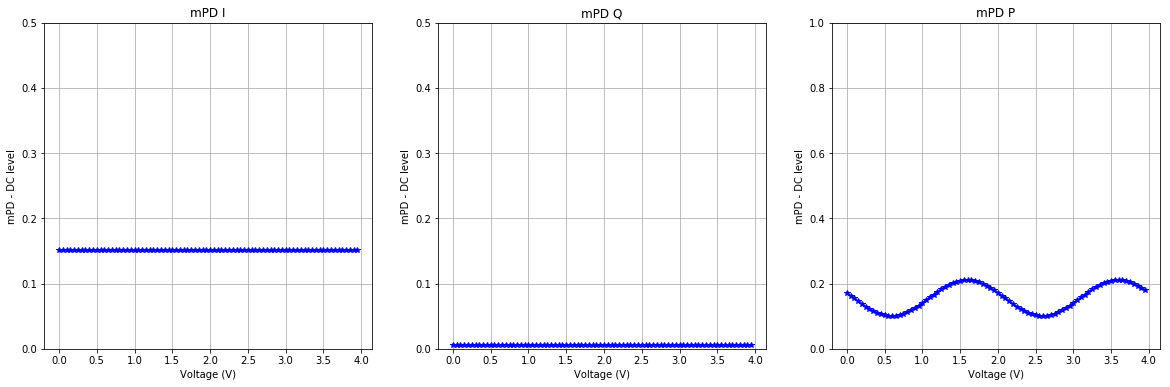

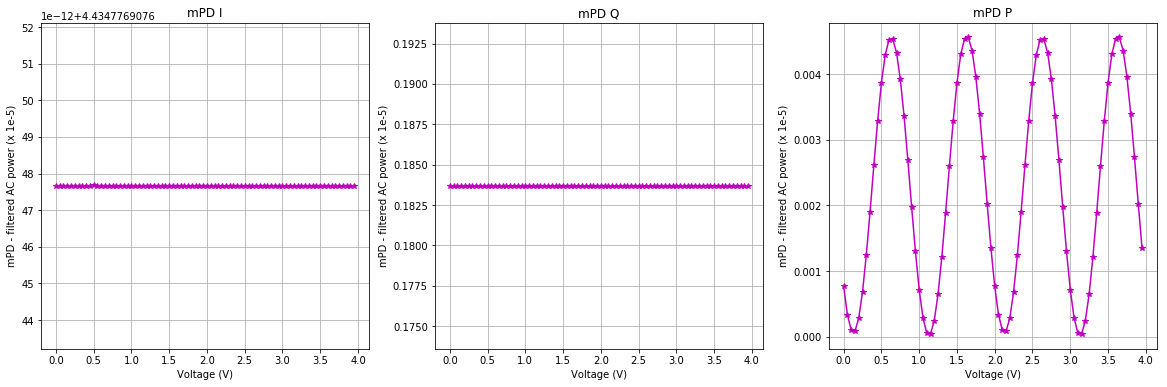

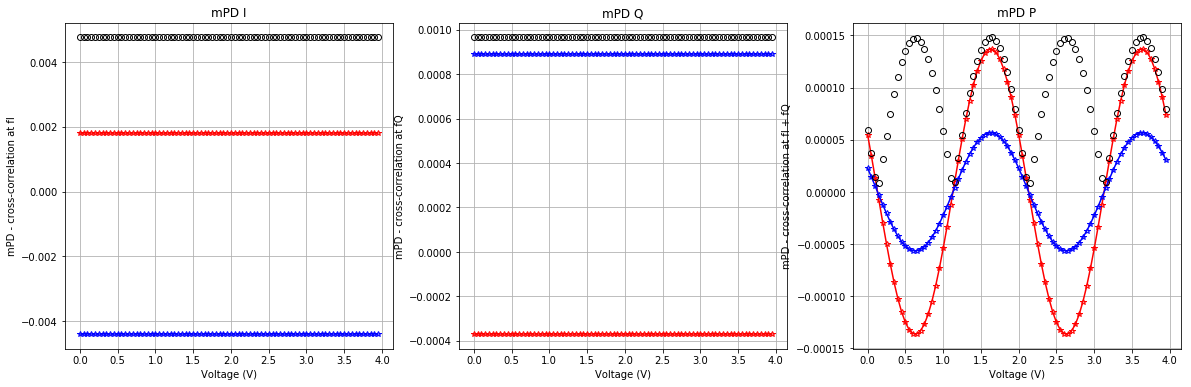

In [32]:
# plotting DC

fig1, axes1 = plt.subplots(1, 3, figsize = (20, 6))

axes1[0].plot(bias_dc_array, DC_level_I, 'b*-')
axes1[0].set_xlabel('Voltage (V)')
axes1[0].set_ylabel('mPD - DC level')
axes1[0].set_ylim([0, 0.5])
axes1[0].set_title('mPD I')
axes1[0].grid('on')

axes1[1].plot(bias_dc_array, DC_level_Q, 'b*-')
axes1[1].set_xlabel('Voltage (V)')
axes1[1].set_ylabel('mPD - DC level')
axes1[1].set_ylim([0, 0.5])
axes1[1].set_title('mPD Q')
axes1[1].grid('on')

axes1[2].plot(bias_dc_array, DC_level_IQ, 'b*-')
axes1[2].set_xlabel('Voltage (V)')
axes1[2].set_ylabel('mPD - DC level')

axes1[2].set_ylim([0, 1])
axes1[2].set_title('mPD P')
axes1[2].grid('on')

# plotting AC filtered power

fig2, axes2 = plt.subplots(1, 3, figsize = (20, 6))

axes2[0].plot(bias_dc_array, AC_pwr_I / 1e-5, 'm*-')
axes2[0].set_xlabel('Voltage (V)')
axes2[0].set_ylabel('mPD - filtered AC power (x 1e-5)')
#axes2[0].set_ylim([0, 10])
axes2[0].set_title('mPD I')
axes2[0].grid('on')

axes2[1].plot(bias_dc_array, AC_pwr_Q / 1e-5, 'm*-')
axes2[1].set_xlabel('Voltage (V)')
axes2[1].set_ylabel('mPD - filtered AC power (x 1e-5)')
#axes2[1].set_ylim([0, 10])
axes2[1].set_title('mPD Q')
axes2[1].grid('on')

axes2[2].plot(bias_dc_array, AC_pwr_IQ / 1e-5, 'm*-')
axes2[2].set_xlabel('Voltage (V)')
axes2[2].set_ylabel('mPD - filtered AC power (x 1e-5)')
#axes2[2].set_ylim([0, 20])
axes2[2].set_title('mPD P')
axes2[2].grid('on')

# plotting cross-correlation

fig3, axes3 = plt.subplots(1, 3, figsize = (20, 6))

axes3[0].plot(bias_dc_array, XCorr_I.real, 'r*-', 
              bias_dc_array, XCorr_I.imag, 'b*-', 
             bias_dc_array, np.abs(XCorr_I), 'ko', fillstyle = 'none')
axes3[0].set_xlabel('Voltage (V)')
axes3[0].set_ylabel('mPD - cross-correlation at fI')
#axes3[0].set_ylim([-1e-2, 1e-2])
axes3[0].set_title('mPD I')
axes3[0].grid('on')

axes3[1].plot(bias_dc_array, XCorr_Q.real, 'r*-', 
              bias_dc_array, XCorr_Q.imag, 'b*-', 
              bias_dc_array, np.abs(XCorr_Q), 'ko', fillstyle = 'none')
axes3[1].set_xlabel('Voltage (V)')
axes3[1].set_ylabel('mPD - cross-correlation at fQ')
#axes3[1].set_ylim([-1e-2, 1e-2])
axes3[1].set_title('mPD Q')
axes3[1].grid('on')

axes3[2].plot(bias_dc_array, XCorr_IQ.real, 'r*-', 
              bias_dc_array, XCorr_IQ.imag, 'b*-', 
             bias_dc_array, np.abs(XCorr_IQ), 'ko', fillstyle = 'none')
axes3[2].set_xlabel('Voltage (V)')
axes3[2].set_ylabel('mPD - cross-correlation at fI + fQ')
#axes3[2].set_xlim([0.5 - 0.3, 0.5 + 0.3])
#axes3[2].set_ylim([-1e-2, 1e-2])
axes3[2].set_title('mPD P')
axes3[2].grid('on')


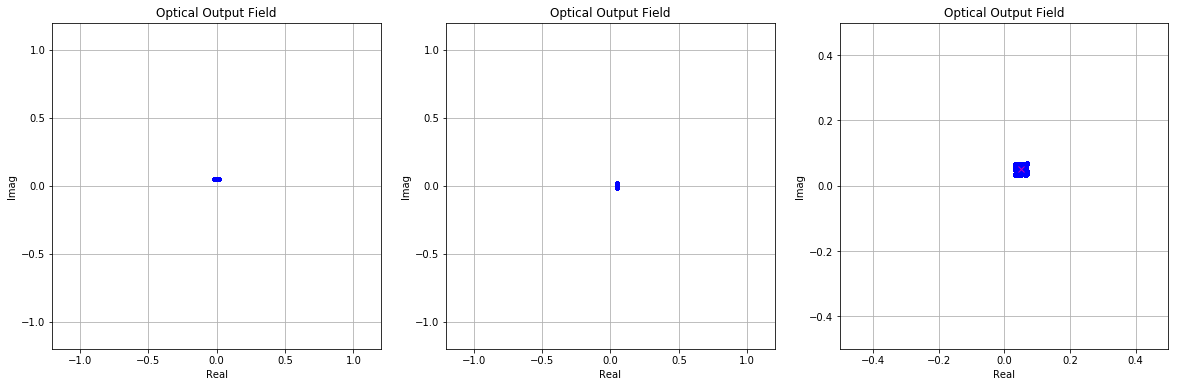

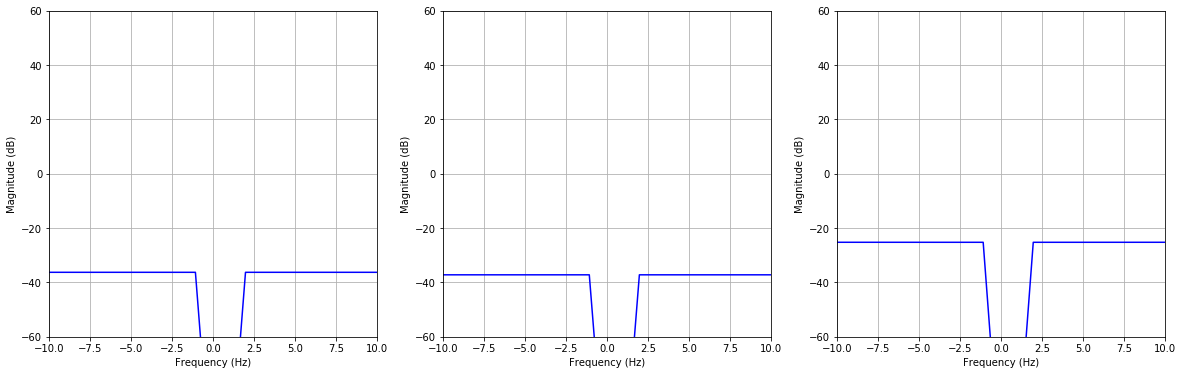

In [28]:
idx = 10
n = 0

time = awg.time[::down_samp]
frequency = awg.frequency[::down_samp]

V_ac_f = np.fft.fftshift(np.fft.fft(V_ac[n,idx,:]))
V_I_ac_f = np.fft.fftshift(np.fft.fft(V_I_ac[n,idx,:]))
V_Q_ac_f = np.fft.fftshift(np.fft.fft(V_Q_ac[n,idx,:]))

# plotting PD spectrum

fig5, axes5 = plt.subplots(1, 3, figsize = (20, 6))

axes5[0].plot(np.real(Eout_I[n,idx,:]), np.imag(Eout_I[n,idx,:]), 'b.')
axes5[0].set_xlabel('Real')
axes5[0].set_ylabel('Imag')
axes5[0].set_xlim(-1.2, 1.2)
axes5[0].set_ylim(-1.2, 1.2)
axes5[0].set_title('Optical Output Field')
axes5[0].grid('on')

axes5[1].plot(np.real(Eout_Q[n,idx,:]), np.imag(Eout_Q[n,idx,:]), 'b.')
axes5[1].set_xlabel('Real')
axes5[1].set_ylabel('Imag')
axes5[1].set_xlim(-1.2, 1.2)
axes5[1].set_ylim(-1.2, 1.2)
axes5[1].set_title('Optical Output Field')
axes5[1].grid('on')

axes5[2].plot(np.real(Eout[n,idx,:]), np.imag(Eout[n,idx,:]), 'b.',
              np.real(np.mean(Eout[n,idx,:])), np.imag(np.mean(Eout[n,idx,:])), 'xm')
axes5[2].set_xlabel('Real')
axes5[2].set_ylabel('Imag')
axes5[2].set_xlim(-0.5, 0.5)
axes5[2].set_ylim(-0.5, 0.5)
axes5[2].set_title('Optical Output Field')
axes5[2].grid('on')

# plotting PD spectrum

fig4, axes4 = plt.subplots(1, 3, figsize = (20, 6))

axes4[0].plot(frequency, 10 * np.log10(abs(V_I_ac_f)), 'b-')
axes4[0].set_xlabel('Frequency (Hz)')
axes4[0].set_ylabel('Magnitude (dB)')
axes4[0].set_xlim([-10, 10])
axes4[0].set_ylim([-60, 60])
axes4[0].grid('on')

axes4[1].plot(frequency, 10 * np.log10(abs(V_Q_ac_f)), 'b-')
axes4[1].set_xlabel('Frequency (Hz)')
axes4[1].set_ylabel('Magnitude (dB)')
axes4[1].set_xlim([-10, 10])
axes4[1].set_ylim([-60, 60])
axes4[1].grid('on')

axes4[2].plot(frequency, 10 * np.log10(abs(V_ac_f)), 'b-')
axes4[2].set_xlabel('Frequency (Hz)')
axes4[2].set_ylabel('Magnitude (dB)')
axes4[2].set_xlim([-10, 10])
axes4[2].set_ylim([-60, 60])
axes4[2].grid('on')

In [ ]:
V_I_ac.shape

In [ ]:
awg.time.size

In [ ]:
DC_level_IQ

In [ ]:
bias_dc_array[np.abs(XCorr_IQ) == np.abs(XCorr_IQ).min()]

In [ ]:
bias_dc_array[63]

In [ ]:
DC_level_IQ == DC_level_IQ.min()